# Non  Negative matrix Factorization

In [1]:
import os
import sys
import re

parent_directory = os.path.abspath('..')
sys.path.append(parent_directory)

from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from Preprocess import preprocess
from Plot import plot_df
from gensim.models import Nmf


# Run the preprocessing 
df= preprocess('Data/articles.json')

# Create a dictionary from the tokenized documents
dictionary = Dictionary(df['content'])#

common_corpus = [dictionary.doc2bow(text) for text in df['content']]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/faculty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/faculty/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/faculty/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Hyperparameter Tuning

In [ ]:
from itertools import product
from gensim.models import Nmf
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from Preprocess import preprocess


# Define the parameter grid
param_grid = {
    'num_topics': [5, 10, 20, 28],  # Number of topics
    'kappa': [0.01, 0.1, 0.5],  # Training step size
    'eval_every': [2, 5, 10]  # Evaluation interval
}

# Perform grid search
best_score = float('-inf')
best_model = None

for params in product(*param_grid.values()):
    kwargs = dict(zip(param_grid.keys(), params))
    nmf = Nmf(common_corpus, **kwargs)
    coherence_model = CoherenceModel(model=nmf, texts=df['content'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    if coherence_score > best_score:
        best_score = coherence_score
        best_model = nmf

print("Number of topics:", best_model.num_topics)
print("Kappa:", best_model.kappa)
print("Evaluation interval:", best_model.eval_every)

In [ ]:
print("Number of topics:", 28)
print("Kappa:", 1)
print("Evaluation interval:", 2)

# Train model

In [41]:
import re
from gensim.models.nmf import Nmf

Num_topics = 28

# Creating an instance of the NMF model
nmf = Nmf(common_corpus, num_topics=Num_topics, kappa=1, eval_every=3)

# Getting the topics using the get_topics() method
topics = nmf.print_topics(num_topics=40, num_words=10)

# Function to extract integer values
def extract_values(topic):
    # We're using a regex that matches digits inside the quotes
    values = re.findall(r'"(\d+)"', topic)
    return [dictionary[int(value)] for value in values]

# Applying the function to your data
result = [extract_values(topic[1]) for topic in topics]

# Print the result
for r in result:
    print(r)


['natur', 'england', 'work', 'habitat', 'local', 'site', 'protect', 'area', 'wildlif', 'nation']
['zone', 'premis', 'surveil', 'near', 'km', 'aiv', 'control', 'bird', 'diseas', 'follow']
['health', 'research', 'use', 'data', 'public', 'uk', 'care', 'innov', 'improv', 'develop']
['uk', 'govern', 'busi', 'trade', 'state', 'industri', 'support', 'secretari', 'minist', 'regul']
['climat', 'uk', 'global', 'countri', 'cop', 'develop', 'intern', 'world', 'commit', 'financ']
['flood', 'work', 'defenc', 'busi', 'scheme', 'resili', 'invest', 'coastal', 'risk', 'project']
['fish', 'river', 'fisheri', 'licenc', 'climat', 'stock', 'regul', 'angler', 'angl', 'environ']
['agenc', 'environ', 'use', 'water', 'river', 'improv', 'open', 'share', 'live', 'local']
['need', 'work', 'year', 'farmer', 'make', 'farm', 'also', 'want', 'busi', 'time']
['flood', 'risk', 'agenc', 'environ', 'commun', 'local', 'govern', 'coastal', 'use', 'live']
['water', 'compani', 'bath', 'qualiti', 'year', 'pollut', 'improv', 's

In [42]:
nmf.save('nmf_model')

In [43]:
nmf_model = Nmf.load('nmf_model')

# Coherence

In [44]:
from Plot import print_coherence
dic = dictionary
print_coherence(dic, result,df['content'])

Topic: natur,england,work,habitat,local,site,protect	Coherence: 0.46
Topic: zone,premis,surveil,near,km,aiv,control,bird,	Coherence: 0.82
Topic: health,research,use,data,public,uk,care,innov	Coherence: 0.40
Topic: uk,govern,busi,trade,state,industri,support,s	Coherence: 0.50
Topic: climat,uk,global,countri,cop,develop,intern,w	Coherence: 0.72
Topic: flood,work,defenc,busi,scheme,resili,invest,c	Coherence: 0.62
Topic: fish,river,fisheri,licenc,climat,stock,regul,	Coherence: 0.64
Topic: agenc,environ,use,water,river,improv,open,sha	Coherence: 0.42
Topic: need,work,year,farmer,make,farm,also,want,bus	Coherence: 0.50
Topic: flood,risk,agenc,environ,commun,local,govern,	Coherence: 0.48
Topic: water,compani,bath,qualiti,year,pollut,improv	Coherence: 0.53
Topic: project,fund,commun,technolog,research,suppor	Coherence: 0.52
Topic: environ,busi,use,report,project,local,agenc,l	Coherence: 0.44
Topic: wast,environ,agenc,site,environment,illeg,cri	Coherence: 0.52
Topic: govern,servic,local,improv,

# Dynamic NMF

In [47]:
topic_proportions = nmf.get_document_topics(common_corpus, minimum_probability=None, normalize=None )
topic_proportions = list(topic_proportions)

def Check_sublists(proportions, x):
# iterating over each sublist
    for sublist in proportions:
        indices = set(x[0] for x in sublist)  # set of indices in current sublist
        for i in range(x):  # assuming indices 0-4
            if i not in indices:
                # find the position to insert the missing tuple
                position = len([x for x in sublist if x[0] < i])
                sublist.insert(position, (i, 0))
Check_sublists(topic_proportions, Num_topics)

/tmp/ipykernel_133/2649582137.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  topic_means = df_copy.groupby('year-month').mean()


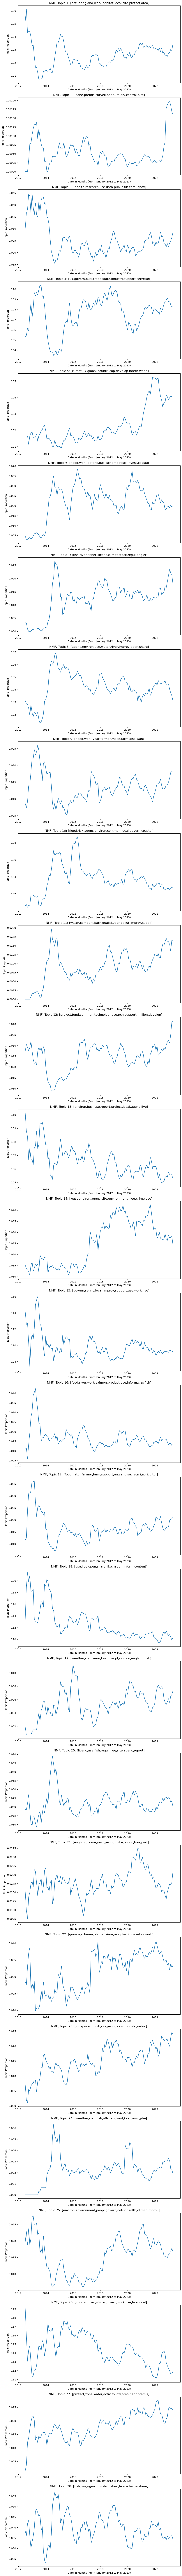

In [49]:
df_copy = df.copy()
# Calculate the topic proportions for each document
# Add the topic proportions to the DataFrame
for i, topic in enumerate(result):
    topic_name = str(','.join(topic[:8]))
    df_copy[topic_name] = [doc_topic[i][1] for doc_topic in topic_proportions]

topic_means = df_copy.groupby('year-month').mean()

plot_df(topic_means, 'NMF', add_error_bars=False)